In [1]:

import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sys
import time

import pyscipopt
import pathlib2

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import matthews_corrcoef, accuracy_score, confusion_matrix, f1_score, balanced_accuracy_score
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

from os import path
while not path.exists("README.MD"):
    os.chdir('..')

from tools.auxiliary_functions import run_SCIP

# Data preporation

## Variables features loading

In [2]:
def load_features(path):
    dfs = []

    for filename in os.listdir(path):
        df = pd.read_csv(os.path.join(os.getcwd(), path, filename))
        dfs.append(df)

    df = pd.concat(dfs)
    return df

In [3]:
df = load_features(os.path.join('data', 'blend', 'features'))
#df = df[(df.scenario == 1664186663) | (df.scenario == 1664186672)]
scenarios = df.scenario.unique()
df.head()

,var,scenario,varBinaryOriginal,varTypeTrans,varStatus,varMayRoundUp,varMayRoundDown,varMayIsActive,varIsDeletable,varIsRemovable,...,varGetNCliques1,varConflictScore,varAvgInferenceScore,relaxSolVal,varImplRedcost0,varImplRedcost1,varPseudocostScore,equalToLb,equalToUb,target
0,x84,1664186663,1,0,3,1,1,0,0,0,...,0,1.000000e-12,1.000000e-12,0,1.000000e+99,1.000000e+99,1.0,1,0,1
1,x85,1664186663,1,0,1,0,0,1,0,0,...,1,1.000000e-12,1.000000e+00,0,1.000000e+99,1.000000e+99,1.0,1,0,1
2,x86,1664186663,1,0,1,0,0,1,0,0,...,0,1.000000e-12,1.000000e-06,0,1.000000e+99,1.000000e+99,1.0,1,0,0
3,x87,1664186663,1,0,1,0,0,1,0,0,...,0,1.000000e-12,1.000000e-06,0,1.000000e+99,1.000000e+99,1.0,1,0,0
4,x88,1664186663,1,0,1,0,0,1,0,0,...,0,1.000000e-12,1.000000e-06,0,1.000000e+99,1.000000e+99,1.0,1,0,1


## The list of problems

In [4]:
df.scenario.unique()

array([1664186663, 1664186672, 1664186741, 1664186792, 1664186899,
       1664186722, 1664186865, 1664186685, 1664186875, 1664186889])

# ML Model 

In [5]:
def crossprediction_in_scenarios(df, mod, x_cols, y_col):
    r = []
    ss = StandardScaler()
    for scenario in df['scenario'].unique():
        print(f'scenario: {scenario:<22} is processing...')
        x_tr = df[df.scenario != scenario][x_cols]
        y_tr = df[df.scenario != scenario][y_col]

        x_val = df[df.scenario == scenario][x_cols]
        y_val = df[df.scenario == scenario][y_col]

        tr = ss.fit_transform(x_tr)
        vl = ss.transform(x_val)
        
        mod.fit(tr, y_tr)
        pred = mod.predict(vl)
        
        try:
            pred_proba = mod.predict_proba(vl)[:, 1]
        except:
            pred_proba = pred
            
        pred_bin = np.round(pred_proba)
        
        f = pd.DataFrame({'scenario': scenario,
                          'var': df[df.scenario == scenario]['var'],
                          'fact': y_val, 
                          'pred': pred,
                          'pred_proba': pred_proba,
                          'pred_bin': pred_bin
                         })
        r.append(f)
        
    res = pd.concat(r)
    res.pred_proba = np.clip(res.pred_proba, 0, 1)
    res.pred_bin = np.clip(res.pred_bin, 0, 1)
    res.pred = np.clip(res.pred, 0, 1)
    
    return res


In [6]:
x_cols = list(set(df.columns) - set(['var', 'scenario', 'target']))
y_col = 'target'
mod = Ridge()#RandomForestRegressor(200) 
res = crossprediction_in_scenarios(df, mod, x_cols, y_col)
res.sample(5)

scenario: 1664186663             is processing...
scenario: 1664186672             is processing...
scenario: 1664186741             is processing...
scenario: 1664186792             is processing...
scenario: 1664186899             is processing...
scenario: 1664186722             is processing...
scenario: 1664186865             is processing...
scenario: 1664186685             is processing...
scenario: 1664186875             is processing...
scenario: 1664186889             is processing...


,scenario,var,fact,pred,pred_proba,pred_bin
582,1664186899,x1004,0,1.601400e-04,1.601400e-04,0.0
162,1664186792,x241,0,5.857150e-08,5.857150e-08,0.0
245,1664186899,x319,1,6.181191e-01,6.181191e-01,1.0
492,1664186672,x595,1,6.788919e-01,6.788919e-01,1.0
1194,1664186672,x2032,0,5.236393e-01,5.236393e-01,1.0


## vizualization


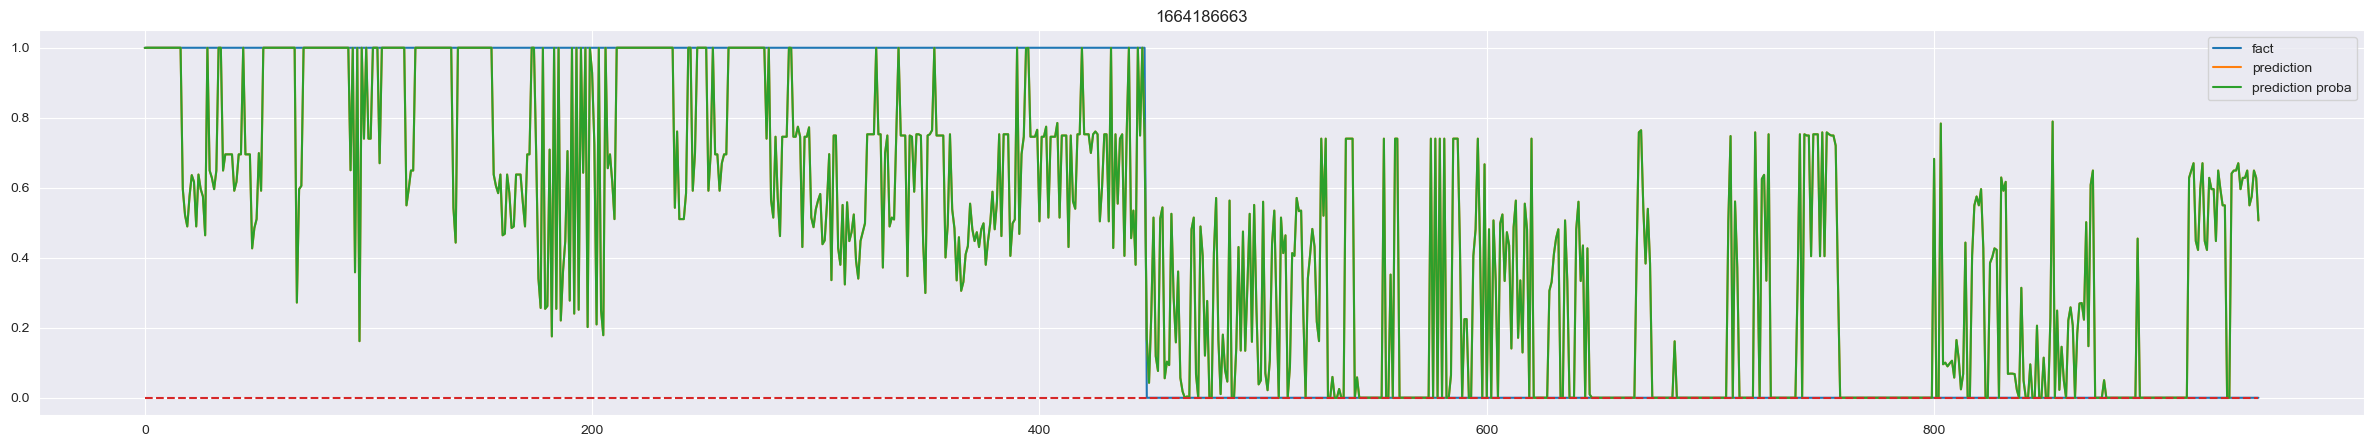

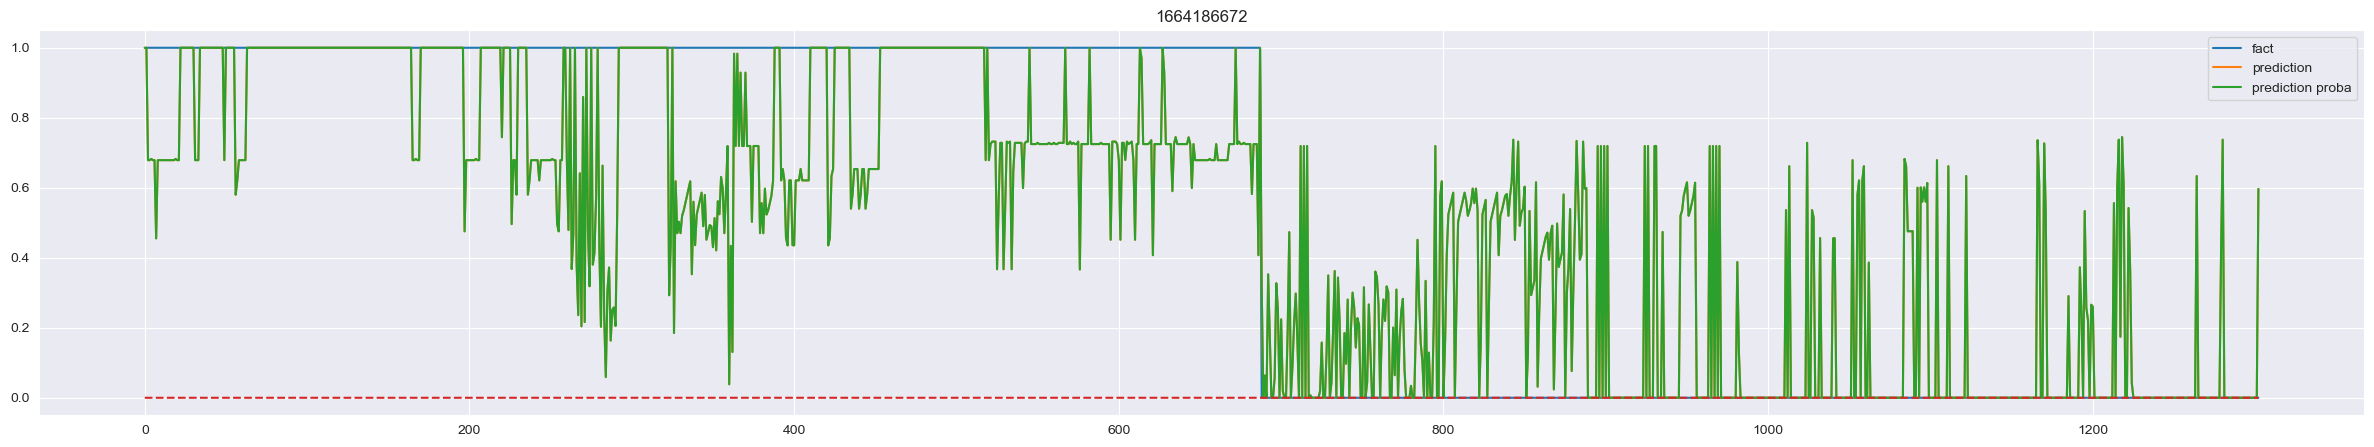

In [7]:
for scenario in scenarios[:2]:
    r = res[res.scenario == scenario].sort_values('fact', ascending=False)
    plt.rcParams["figure.figsize"] = (30, 5)
    plt.plot(range(len(r)), r.fact, label='fact')
    plt.plot(range(len(r)), r.pred, label='prediction')
    plt.plot(range(len(r)), r.pred_proba, label='prediction proba')
    plt.plot(range(len(r)), [0 for i in range(len(r))], '--')
    plt.legend()
    plt.title(scenario)
    plt.show()

- tThe graphs constructed above look promisin it's evident that the regressor has almost no false positive detections
-  Now, let's try to evaluate the obtained forecasted values.

In [8]:
print(f'f1 score: {f1_score(res["fact"], res["pred_bin"]):.2f}')

f1 score: 0.84


In [9]:
confusion_matrix(res["fact"], res["pred_bin"])

array([[4027, 1144],
       [ 515, 4414]])

In [10]:
r = res.copy()
arr = []
for th in [0, .0001, .001, .01, .02, .05, .1, .2, .5]:
    r = res[(res['pred_proba'] <= th) | (res['pred_proba'] >= 1 - th)]
    r['pred2'] = 0
    r.loc[r['pred_proba'] <= th, 'pred2'] = 0
    r.loc[r['pred_proba'] >= 1- th, 'pred2'] = 1
    arr.append([th, len(r), len(r) / len(res), f1_score(r["fact"], r["pred2"])])

d = pd.DataFrame(arr, columns=['fixation threashold', 'number of fixed vars', 'fraction of fixed vars', 'f1 metric for fixation'])
d

,fixation threashold,number of fixed vars,fraction of fixed vars,f1 metric for fixation
0,0.0000,277,0.027426,0.987952
1,0.0001,4249,0.420693,0.999753
2,0.0010,4891,0.484257,0.999769
3,0.0100,4909,0.486040,0.999770
4,0.0200,4923,0.487426,0.999540
5,0.0500,4999,0.494950,0.999314
6,0.1000,5162,0.511089,0.999097
7,0.2000,5444,0.539010,0.993975
8,0.5000,10100,1.000000,0.841804


- as you can see f1 metric is quate stable when fixation threshold is from 0 to 0.2 and drops strongly further.
- it is definitely not worth considering fixation thresholds higher than .2

# Experimentation

In [11]:
def run_SCIP(
    path_to_problem_file: pathlib2.Path,
    vars_to_fix: pd.DataFrame,
    problem_name: str,
):
    """
    run SCIP solver with fixation (vars_to_fix)
    
    path_to_test_lp_file - path to problem file (lp or mps file)
    vars_to_fix - dataframe with fixation 
    problem_name - problem name
    """
    model = pyscipopt.Model()
    model.readProblem(path_to_problem_file)
    #model.setParam("numerics/feastol", 1e-04)
    #model.setParam('numerics/epsilon', 1e-06)
    #model.setParam('numerics/dualfeastol', 1e-05)
    #model.setParam('numerics/sumepsilon', 1e-04)
    model.setParam('limits/time', 2000)
    #model.setParam('limits/gap', .01)
    
    all_vars: t.List[pyscipopt.scip.Variable] = model.getVars()

    all_vars_dct = {var.name: var for var in all_vars}
    fixed = 0
    for ind, row in vars_to_fix.iterrows():
        var = all_vars_dct[row['var']] 
        if row.fixed & (var.vtype() in {'BINARY', 'INTEGER'}):           
            model.fixVar(var, row.value)
            fixed += 1
    print(f'{fixed} variables fixed')
    model.optimize()

    return model


def run_SCIP_with_fixation(fixation: pd.DataFrame, fn: str):
    '''
    wrapper for run_SCIP
    fixation - dataframe with fixation 
    fn - - path to problem file (lp or mps file)
    '''
    try:
        start_time = time.time()
        model = run_SCIP(
                path_to_problem_file=pathlib2.Path(os.getcwd(), 'data', 'blend', 'problems', fn),
                vars_to_fix=fixation,
                problem_name='test')
        end_time = time.time()
        tm = int(end_time - start_time)
        obj = int(model.getObjVal())
    except Exception as ex:
        print(ex)
        tm = None
        obj = None
        print('something wrong with fixation...' ) 
    
    return tm, obj
    

## Experiments


### 1. Without fixation

In [12]:

df_no_fixation = pd.DataFrame(
    {
        'scenario': [1664186663, 1664186672, 1664186685, 1664186722, 1664186741, 1664186792, 1664186865, 1664186875, 1664186889, 1664186899],
        'time_no_fix': [390, 334, 449, 330, 564, 323, 489, 123, 250, 291]
    }, 
)

'''
df_no_fixation = []

for scenario in scenarios:   
    print('')
    print(f'problem {scenario} is processing....')
    fn = str(scenario) + '.lp'
    fixation = res[(res['scenario'] == scenario)].copy()
    fixation['fixed'] = False
    time_no_fixed, obj_no_fixed = run_SCIP_with_fixation(fixation, fn)
    print(f'{scenario} time: {time_no_fixed}')
    
    df_no_fixation.append([scenario, time_no_fixed, obj_no_fixed])
     
df_no_fixation = pd.DataFrame(df_no_fixation, columns=['scenario', 'time_no_fixed', 'obj_no_fixed'])
df_no_fixation
'''

"\ndf_no_fixation = []\n\nfor scenario in scenarios:   \n    print('')\n    print(f'problem {scenario} is processing....')\n    fn = str(scenario) + '.lp'\n    fixation = res[(res['scenario'] == scenario)].copy()\n    fixation['fixed'] = False\n    time_no_fixed, obj_no_fixed = run_SCIP_with_fixation(fixation, fn)\n    print(f'{scenario} time: {time_no_fixed}')\n    \n    df_no_fixation.append([scenario, time_no_fixed, obj_no_fixed])\n     \ndf_no_fixation = pd.DataFrame(df_no_fixation, columns=['scenario', 'time_no_fixed', 'obj_no_fixed'])\ndf_no_fixation\n"

### 2. Zero variables fixing

In [13]:
df_zero_fixation = []

for scenario in scenarios:   
    print('')
    print(f'problem {scenario} is processing....')
    fn = str(scenario) + '.lp'
    fixation = res[(res['scenario'] == scenario)].copy()

    threashold = fixation.pred_proba.quantile(.1)
    fixation['fixed'] = False
    fixation.loc[fixation['pred_proba'] <= threashold, 'fixed'] = True
    fixation.loc[fixation['pred_proba'] <= threashold, 'value'] = 0
    time_zero_fixed, ob_zero_fixed = run_SCIP_with_fixation(fixation, fn)
    print(f'{scenario} time: {time_zero_fixed}')
    df_zero_fixation.append([scenario,  time_zero_fixed, ob_zero_fixed])

df_zero_fixation = pd.DataFrame(df_zero_fixation, columns=['scenario', 'time_zero_fixed', 'obj_zero_fixed'])
df_zero_fixation.head()


problem 1664186663 is processing....
original problem has 2410 variables (946 bin, 0 int, 0 impl, 1464 cont) and 4803 constraints
204 variables fixed
presolving:
(round 1, fast)       786 del vars, 657 del conss, 0 add conss, 2026 chg bounds, 588 chg sides, 903 chg coeffs, 0 upgd conss, 0 impls, 4 clqs
(round 2, fast)       865 del vars, 1083 del conss, 0 add conss, 2102 chg bounds, 739 chg sides, 1497 chg coeffs, 0 upgd conss, 16 impls, 8 clqs
(round 3, fast)       939 del vars, 1296 del conss, 0 add conss, 2202 chg bounds, 762 chg sides, 1521 chg coeffs, 0 upgd conss, 18 impls, 8 clqs
(round 4, fast)       940 del vars, 1312 del conss, 0 add conss, 2205 chg bounds, 769 chg sides, 1538 chg coeffs, 0 upgd conss, 22 impls, 8 clqs
   (0.0s) running MILP presolver
   (0.0s) MILP presolver (16 rounds): 119 aggregations, 2 fixings, 305 bound changes
(round 5, medium)     1061 del vars, 1312 del conss, 0 add conss, 2511 chg bounds, 769 chg sides, 1538 chg coeffs, 0 upgd conss, 22 impls, 6 c

,scenario,time_zero_fixed,obj_zero_fixed
0,1664186663,55,34229
1,1664186672,157,54660
2,1664186741,427,32648
3,1664186792,252,30015
4,1664186899,179,29554


## Merging results 

In [15]:
res_df = pd.merge(df_no_fixation, df_zero_fixation, on='scenario')
res_df = pd.merge(res_df, df_both_fixation, on='scenario')
res_df.head()

,scenario,time_no_fix,time_zero_fixed,obj_zero_fixed,time_both_fixed,obj_both_fixed
0,1664186663,390,55,34229,46,34229
1,1664186672,334,157,54660,303,54660
2,1664186685,449,538,30227,248,30874
3,1664186722,330,135,28226,200,28226
4,1664186741,564,427,32648,245,32648


# Results

In [16]:
k1 = res_df.time_no_fix.sum() / res_df.time_zero_fixed.sum()
k2 = res_df.time_no_fix.sum() / res_df.time_both_fixed.sum()

print(f'zero fixation increased speed of SCIP solver in           {k1:.2f} times')
print(f'zero fixation increased speed of SCIP solver in  {k2:.2f} times')

zero fixation increased speed of SCIP solver in           1.52 times
zero and ones fixation increased speed of SCIP solver in  1.55 times


# visualization

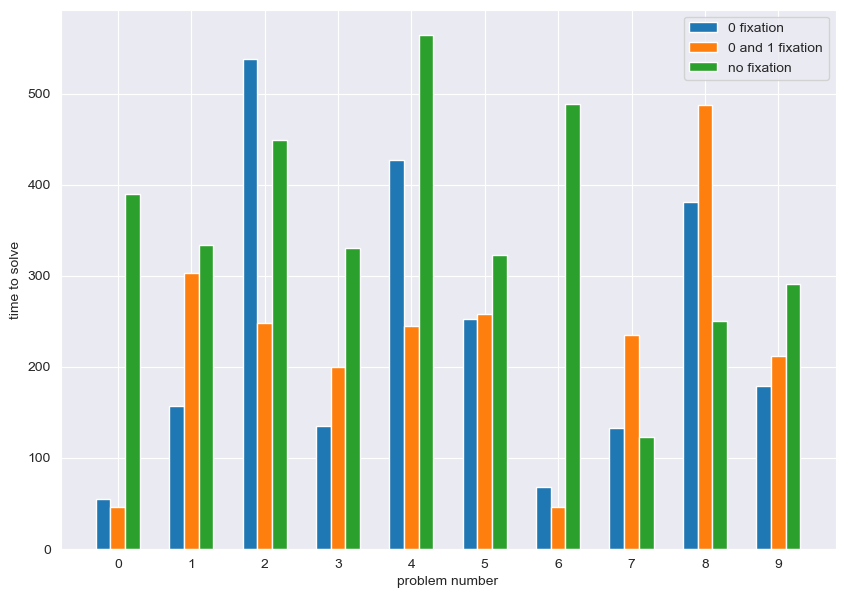

In [17]:
plt.rcParams["figure.figsize"] = (10, 7)
plt.bar(res_df.index - 0.2, res_df['time_zero_fixed'], 0.2, label = '0 fixation') 
plt.bar(res_df.index + 0.2, res_df['time_no_fix'], 0.2, label = 'no fixation') 
  
plt.xticks(res_df.index , res_df.index) 
plt.xlabel("problem number") 
plt.ylabel("time to solve") 
plt.title("") 
plt.legend() 
plt.show() 